In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSSBB'
m='SNOW'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=5.2.2 	required version>=6.0.0 ******* Update Version ******


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
data_dir='../../Data/Weather'
file_index='SSSBSSBB'

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [7]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    640.1|  37.495|-119.9858|       SNOW|USC00045352|     0|[00 00 00 00 00 0...|1985.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNOW|USC00045352|    31|[00 00 00 00 00 0...|1986.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNOW|USC00045352|    31|[00 00 00 00 00 0...|1988.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNOW|USC00045352|     0|[00 00 00 00 00 0...|1989.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNOW|USC00045352|    30|[00 00 00 00 00 0...|1990.0|SSSBSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [8]:
#rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
dfnew=df.limit(1)
rows2=dfnew.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
t2=np.vstack(rows2)
print type(t2)
s=nansum(t2,axis=1)
s
#T=np.vstack(rows)
#shape(T)

<type 'numpy.ndarray'>


array([ 0.], dtype=float16)

In [9]:
print type(t2)
s=nansum(t2,axis=1)
s

<type 'numpy.ndarray'>


array([ 0.], dtype=float16)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

NameError: name 'T' is not defined

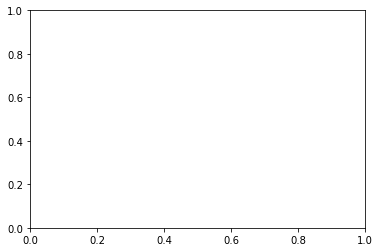

In [10]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

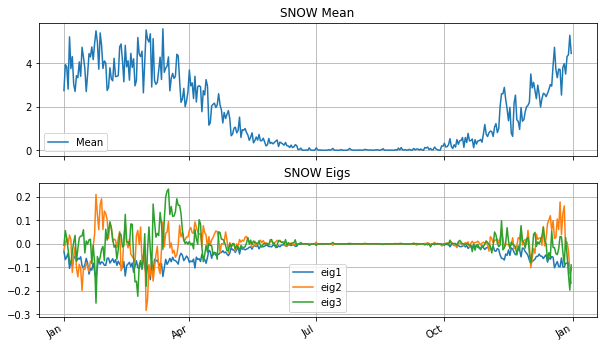

In [11]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

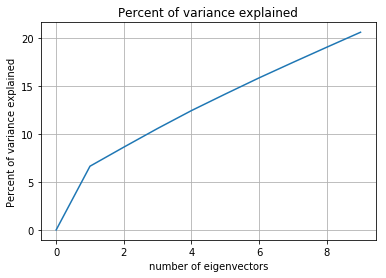

In [12]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [13]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

NameError: name 'T' is not defined

In [14]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

NameError: name 'eigen_decomp' is not defined

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [16]:
rows=df.take(3)
L=[]
for row in rows:
    row_out=decompose(row,Mean,v)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

TypeError: decompose() takes exactly 1 argument (3 given)

In [15]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [16]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1890
after filter 820


In [44]:
#df3=df3.sort(df3.res_3,ascending=True)
#rows=df3.take(12)


In [17]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [66]:
df4=df3.sort(df3.coeff_1)
rows=df4.take(12)
dfrows2=df4.limit(12)
rows2=dfrows2.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
c1mat1=dfrows2.rdd.map(lambda row:row['coeff_1']).collect()

t=np.vstack(rows2)
s1= list(nansum(t,axis=1))
print s                    
df4.select('res_mean','res_1','res_2','res_3').show(4)

[19632.0, 17216.0, 13640.0, 16816.0, 15840.0, 14472.0, 13832.0, 15200.0, 12568.0, 15992.0, 14992.0, 14784.0]
+------------------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|
+------------------+------------------+------------------+------------------+
|0.8946025645454766|0.8435399291879508|0.7424992210436744|0.7245887961070919|
|0.8713880119437531|0.8272398941660155|0.7432688005727334|0.6915294988780233|
|0.8803518652730052|0.8356071125553364|0.8350360912891921|0.6027694890482412|
|0.8730065077650895|0.8371828324545394|0.7446148826792065|0.6852682085811107|
+------------------+------------------+------------------+------------------+
only showing top 4 rows



In [65]:
c1mat

[(-980.9187195395816, numpy.float16),
 (-890.570206312235, numpy.float16),
 (-856.6292675760533, numpy.float16),
 (-854.9515109788501, numpy.float16),
 (-853.1647406966197, numpy.float16),
 (-848.0611769678314, numpy.float16),
 (-825.1382116952625, numpy.float16),
 (-789.9583809360829, numpy.float16),
 (-777.42392258805, numpy.float16),
 (-751.5820748556021, numpy.float16),
 (-743.7679569841621, numpy.float16),
 (-731.3911480870099, numpy.float16)]

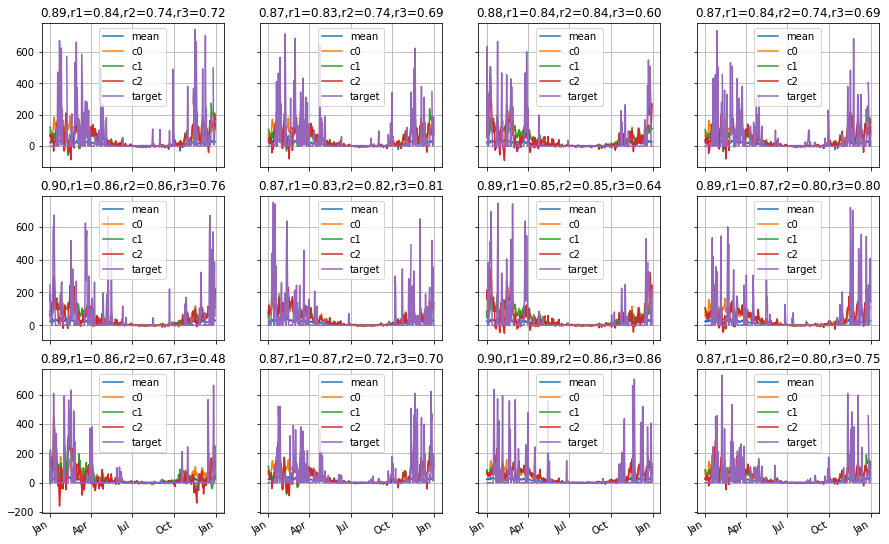

In [59]:
plot_recon_grid(rows)

In [68]:
df5=df3.sort(df3.coeff_1,ascending=False)
rows=df5.take(12)
dfrows2=df5.limit(12)
rows2=dfrows2.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
c1mat2=dfrows2.rdd.map(lambda row:row['coeff_1']).collect()
t=np.vstack(rows2)
s2=list(nansum(t,axis=1))
df5.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|
+------------------+------------------+------------------+------------------+
|0.9932429837461855|0.9243887786570885|0.9238046685463871| 0.876994104006874|
| 0.988472123373827|0.8876475325028417|0.8548711098841122|0.8539635427153809|
| 0.999048345964197|0.9538797275440546|0.9538978017510334|0.9459061154019744|
|0.9962018331866719|0.9483185467800345|0.9292445404493498|0.9247258551579624|
+------------------+------------------+------------------+------------------+
only showing top 4 rows



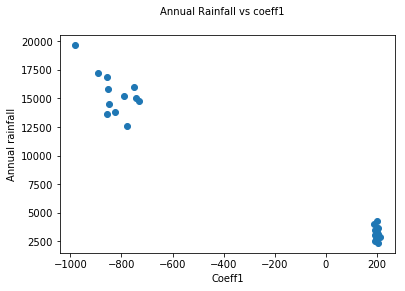

In [81]:
st=s1+s2
st
ct=c1mat1+c1mat2

from matplotlib import pyplot as plt    

fig = plt.figure()
plt.scatter(ct,st)
fig.suptitle('Annual Rainfall vs coeff1', fontsize=10)
plt.xlabel('Coeff1', fontsize=10)
plt.ylabel('Annual rainfall', fontsize=10)
fig.savefig('test.jpg')

#matplotlib.pyplot.scatter(st,ct)

#matplotlib.pyplot.show()

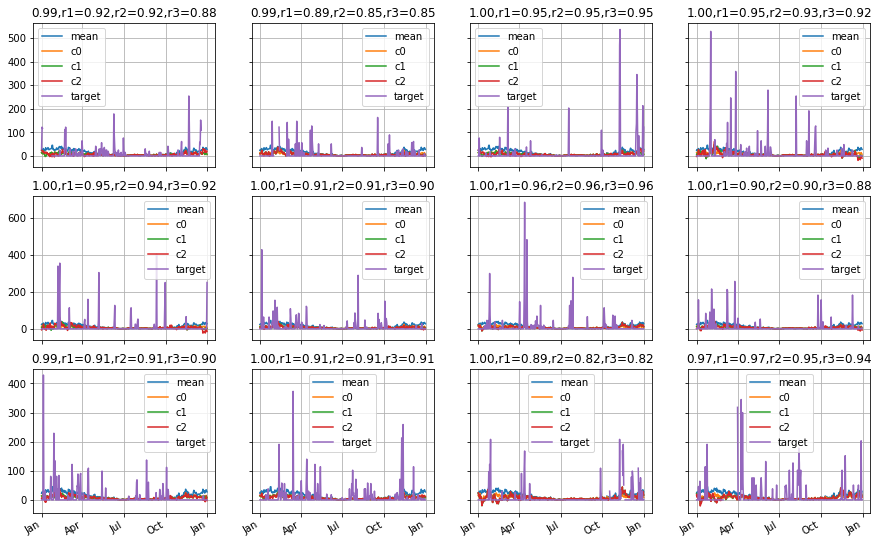

In [61]:
plot_recon_grid(rows)

In [18]:
annualsnow=df3.rdd.map(lambda row:nansum(unpackArray(row['vector'],np.float16))).collect()
elevation=df3.rdd.map(lambda row:row['elevation']).collect()
#t=np.vstack(rows2)
#s2=list(nansum(t,axis=1))
#df5.select('res_mean','res_1','res_2','res_3').show(4)
annualsnow


[1634.0,
 2872.0,
 2660.0,
 2790.0,
 3584.0,
 1604.0,
 3032.0,
 2504.0,
 2568.0,
 4284.0,
 2108.0,
 3770.0,
 4712.0,
 3026.0,
 2794.0,
 2172.0,
 3390.0,
 2122.0,
 1916.0,
 2048.0,
 2260.0,
 2312.0,
 3630.0,
 3452.0,
 2056.0,
 1943.0,
 2768.0,
 2044.0,
 2908.0,
 2846.0,
 942.0,
 2704.0,
 1876.0,
 2294.0,
 2872.0,
 3228.0,
 3502.0,
 1673.0,
 3122.0,
 3704.0,
 3248.0,
 4136.0,
 1725.0,
 1371.0,
 762.0,
 979.0,
 511.0,
 1070.0,
 1041.0,
 940.0,
 262.0,
 1992.0,
 986.0,
 2118.0,
 736.0,
 1170.0,
 1654.0,
 1467.0,
 1041.0,
 1827.0,
 1599.0,
 1279.0,
 2080.0,
 1632.0,
 1460.0,
 1462.0,
 1804.0,
 1030.0,
 1882.0,
 1090.0,
 1637.0,
 1323.0,
 1462.0,
 683.0,
 1366.0,
 2338.0,
 2804.0,
 937.0,
 1363.0,
 388.0,
 1249.0,
 1264.0,
 797.0,
 1697.0,
 758.0,
 1247.0,
 1137.0,
 1960.0,
 1924.0,
 1044.0,
 990.0,
 3368.0,
 1405.0,
 1298.0,
 2312.0,
 2284.0,
 1677.0,
 1837.0,
 1738.0,
 2712.0,
 1335.0,
 2280.0,
 1559.0,
 2031.0,
 2370.0,
 2384.0,
 1699.0,
 2562.0,
 2616.0,
 2408.0,
 2384.0,
 2362.0,
 1846.

In [52]:
dic={}

for x,y in zip(annualsnow,elevation):
    dic.setdefault(y,[]).append(x)   


In [51]:
x=inf
print x

inf


In [54]:
for key in dic.keys():
    
    dic[key]=sum(list(np.array(dic[key])/len(dic[key])))
dic

{323.1: 203.0,
 510.5: 476.0,
 613.0: 389.0,
 637.0: 337.0,
 806.2: 432.5,
 853.4: 377.0,
 854.0: 782.0,
 896.7: 262.0,
 915.0: 887.5,
 951.9: 774.0,
 958.6: 507.0,
 982.1: 828.5,
 1024.1: 782.0,
 1179.6: 1058.0,
 1189.9: 1508.0,
 1224.7: 1015.0,
 1225.9: 513.0,
 1250.3: 449.75,
 1252.1: 305.0,
 1302.7: 899.0,
 1366.1: 917.0,
 1374.6: 1332.0,
 1403.0: 640.5,
 1421.0: 1539.0,
 1434.1: 928.0,
 1452.4: 1557.0,
 1463.0: 293.0,
 1469.1: 412.0,
 1486.8: 1287.0,
 1493.5: 513.5,
 1538.3: 1381.0,
 1556.0: 436.0,
 1592.6: 407.25,
 1644.4: 504.0,
 1664.2: 393.25,
 1734.3: 555.0,
 1800.1: 1448.0,
 1829.4: 489.5,
 1831.8: 698.5,
 1859.3: 546.0,
 1905.0: 971.5,
 1937.0: 700.5,
 1965.7: 1106.0,
 1966.9: 1484.0,
 2071.7: 1188.0,
 2139.7: 2470.0,
 2164.1: 868.0,
 2204.9: 1370.0,
 2378.7: 2644.0,
 2587.8: 1557.0,
 2734.1: 2906.0,
 2763.0: 2160.0,
 2863.9: 1250.0,
 2920.0: 2550.0,
 2939.8: 3672.0,
 3093.7: 1920.0,
 3800.9: 2698.0}

In [59]:
keys, values = zip(*dic.items())

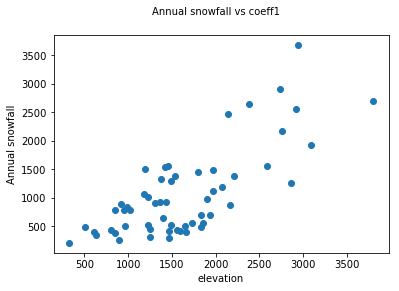

In [56]:
from matplotlib import pyplot as plt    

fig = plt.figure()
plt.scatter(keys,values)
fig.suptitle('Annual snowfall vs coeff1', fontsize=10)
plt.xlabel('elevation', fontsize=10)
plt.ylabel('Annual snowfall', fontsize=10)
fig.savefig('test.jpg')

In [62]:
np.corrcoef(keys,values)

array([[ 1.        ,  0.74281392],
       [ 0.74281392,  1.        ]])

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

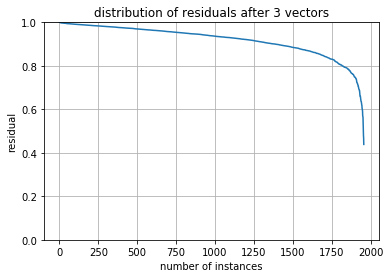

In [24]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [63]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

Py4JJavaError: An error occurred while calling o96.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply$mcV$sp(FileFormatWriter.scala:147)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:121)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:121)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:121)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:101)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:58)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:56)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.doExecute(commands.scala:74)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:87)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:87)
	at org.apache.spark.sql.execution.datasources.DataSource.write(DataSource.scala:492)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:215)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:198)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:494)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 15.0 failed 1 times, most recent failure: Lost task 1.0 in stage 15.0 (TID 29, localhost, executor driver): java.io.IOException: (null) entry in command string: null chmod 0644 C:\Users\Sai\Documents\GitHub\CSE255-DSE230\Data\Weather\decon_SSSBSSBB_SNOW.parquet\_temporary\0\_temporary\attempt_20170515212837_0015_m_000001_0\part-00001-c151745b-6e9b-4bc6-b207-cb96673c230f.snappy.parquet
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:770)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:866)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:849)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:733)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:225)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:209)
	at org.apache.hadoop.fs.RawLocalFileSystem.createOutputStreamWithMode(RawLocalFileSystem.java:307)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:296)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:328)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.<init>(ChecksumFileSystem.java:398)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:461)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:892)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:789)
	at org.apache.parquet.hadoop.ParquetFileWriter.<init>(ParquetFileWriter.java:223)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:312)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:283)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:37)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anon$1.newInstance(ParquetFileFormat.scala:145)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$SingleDirectoryWriteTask.<init>(FileFormatWriter.scala:234)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:182)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1$$anonfun$3.apply(FileFormatWriter.scala:129)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1$$anonfun$3.apply(FileFormatWriter.scala:128)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply$mcV$sp(FileFormatWriter.scala:127)
	... 31 more
Caused by: java.io.IOException: (null) entry in command string: null chmod 0644 C:\Users\Sai\Documents\GitHub\CSE255-DSE230\Data\Weather\decon_SSSBSSBB_SNOW.parquet\_temporary\0\_temporary\attempt_20170515212837_0015_m_000001_0\part-00001-c151745b-6e9b-4bc6-b207-cb96673c230f.snappy.parquet
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:770)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:866)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:849)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:733)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:225)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:209)
	at org.apache.hadoop.fs.RawLocalFileSystem.createOutputStreamWithMode(RawLocalFileSystem.java:307)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:296)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:328)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.<init>(ChecksumFileSystem.java:398)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:461)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:892)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:789)
	at org.apache.parquet.hadoop.ParquetFileWriter.<init>(ParquetFileWriter.java:223)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:312)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:283)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:37)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anon$1.newInstance(ParquetFileFormat.scala:145)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$SingleDirectoryWriteTask.<init>(FileFormatWriter.scala:234)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:182)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1$$anonfun$3.apply(FileFormatWriter.scala:129)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1$$anonfun$3.apply(FileFormatWriter.scala:128)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [ ]:
!du -sh $data_dir/*.parquet